# INTRUSION DETECTION SYSTEM USING MACHINE LEARNING

## Overall Code Functionality:
The code loads a dataset, preprocesses it by handling missing values and standardizing features, and then splits it into training and testing sets. It trains each of the six models on the training data, evaluates their performance using various metrics (accuracy, F1 score, precision, recall, and ROC AUC), and identifies the best-performing model based on accuracy. Finally, it saves the best model for future use.
The code implements a machine learning pipeline for classifying network intrusion data using the CICIDS2017 dataset. It begins by loading and preprocessing the data, including handling missing values and standardizing features. The dataset is then split into training and testing sets. Six different classification models are trained on the training data, and their performance is evaluated using metrics such as accuracy, F1 score, precision, recall, and ROC AUC. The model with the highest accuracy is selected as the best model, which is then saved for future predictions. This comprehensive approach allows for effective evaluation and comparison of various classification algorithms.

In [3]:
# Data manipulation
import pandas as pd  # For handling data in tabular format
import numpy as np  # For numerical operations

# Visualization
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For heatmaps, boxplots, etc.

# Data preprocessing and splitting
from sklearn.model_selection import train_test_split  # Splitting into training and test sets
from sklearn.preprocessing import StandardScaler  # Standardizing numerical features

# Machine learning models
from sklearn.linear_model import LogisticRegression  # Logistic Regression classifier
from sklearn.tree import DecisionTreeClassifier  # Decision Tree classifier
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
from sklearn.svm import SVC, LinearSVC  # Support Vector Classifiers
from sklearn.calibration import CalibratedClassifierCV  # Probability calibration for classifiers
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier
from sklearn.naive_bayes import GaussianNB  # Naive Bayes classifier

# Model evaluation metrics
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve
)

# For saving/loading models
import joblib  # Persisting trained models

In [4]:
# Load the dataset from CSV file
df = pd.read_csv('CICIDS2017_sample.csv')  # Read dataset from CSV file into a Pandas DataFrame

# Display the first five rows of the dataset to understand its structure
df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
# Show basic shape and sample records
print("Dataset Shape:", df.shape)

# Show columns with missing values
print("\nMissing Values in Each Column:\n", df.isna().sum()[df.isna().sum() > 0])

Dataset Shape: (56661, 78)

Missing Values in Each Column:
 Flow Bytes/s    54
dtype: int64


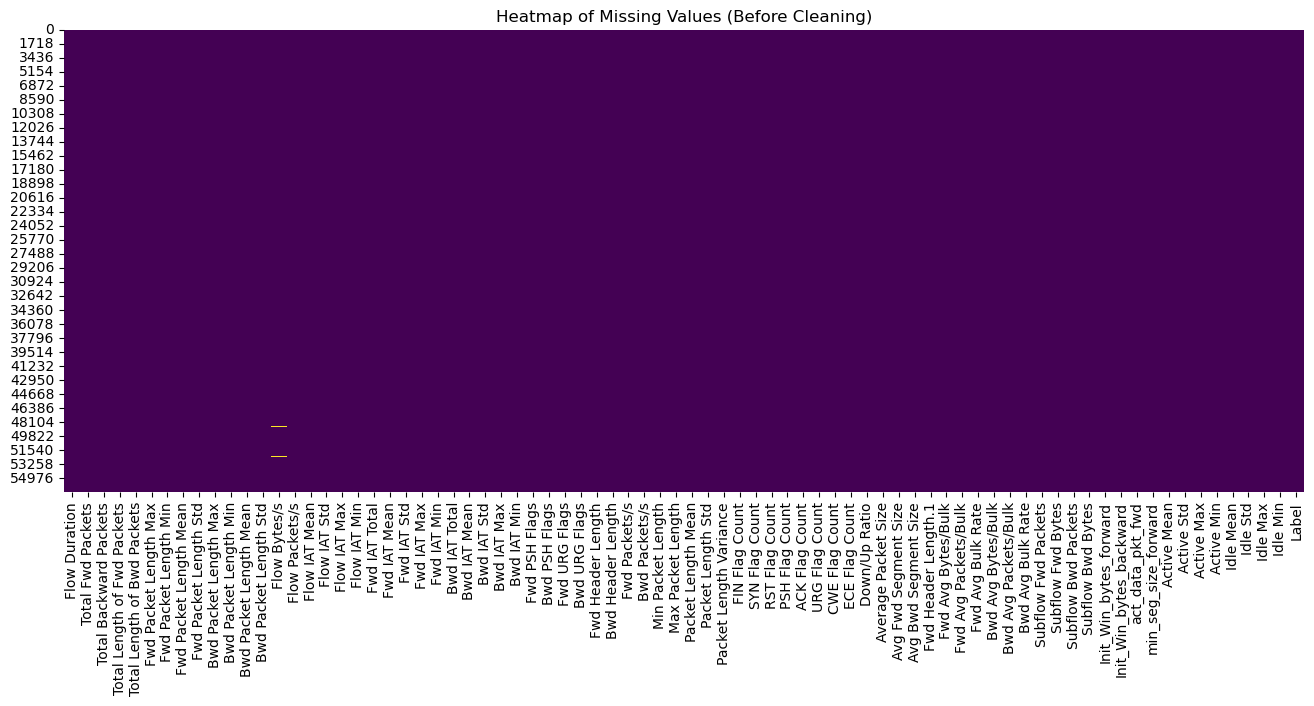

In [6]:
# Show where the missing values are in a heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values (Before Cleaning)")
plt.show()

In [7]:
# Separate features and labels
X = df.drop(columns=['Label'])  # Drop target column to get features
y = df['Label']  # Get the target column

# Convert labels to binary if needed (modify as per dataset)
y = y.apply(lambda x: 0 if x == 'BENIGN' else 1)

# Report missing value status
missing_count = X.isnull().sum().sum()
print(f"Total missing values in X: {missing_count}")
if missing_count > 0:
    print("Missing values found. Filling with mean.")
    X.fillna(X.mean(), inplace=True)
else:
    print("No missing values found.")

# Report infinite value status
infinite_count = np.isinf(X).sum().sum()
print(f"Total infinite values in X: {infinite_count}")
if infinite_count > 0:
    print("Infinite values found. Replacing with max finite value.")
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(X.max(), inplace=True)
else:
    print("No infinite values found.")

Total missing values in X: 54
Missing values found. Filling with mean.
Total infinite values in X: 162
Infinite values found. Replacing with max finite value.


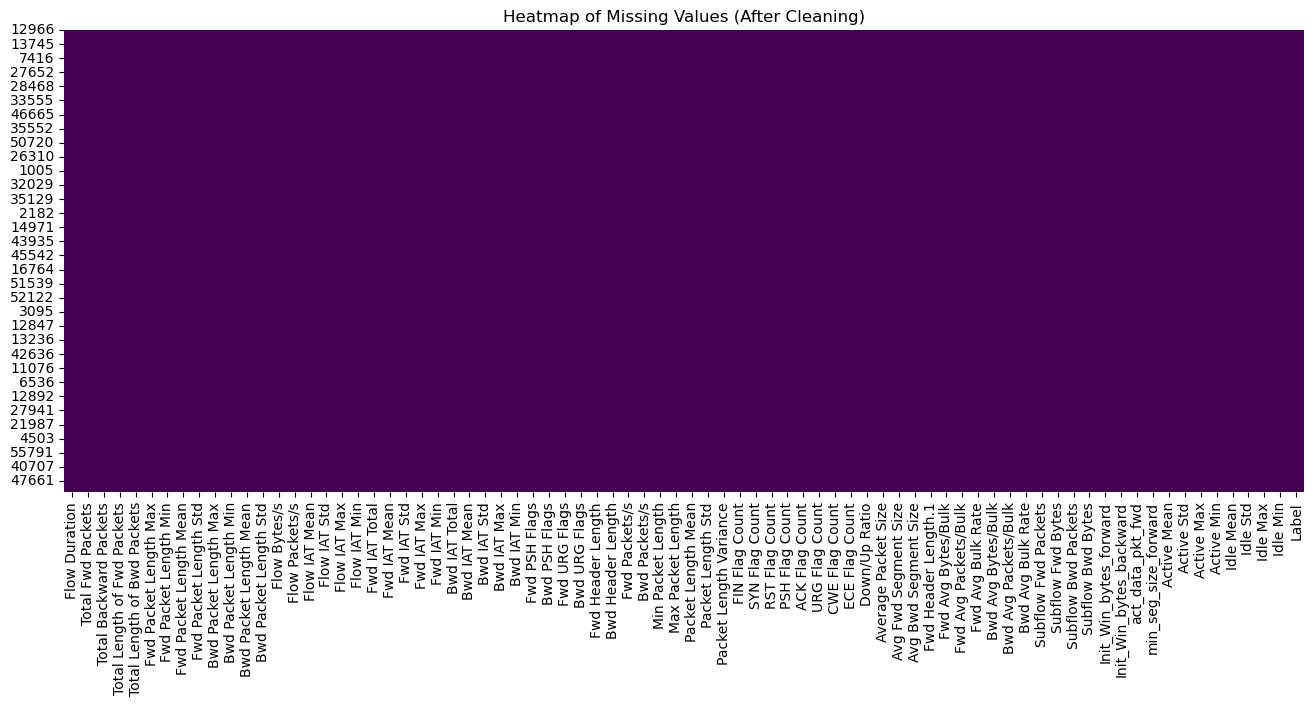

In [8]:
# Sample small portion for visualization to avoid memory issues
sample_df = df.sample(n=2000, random_state=42)

# Heatmap after removing NaNs
plt.figure(figsize=(16, 6))
sns.heatmap(sample_df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values (After Cleaning)")
plt.show()

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Convert "Label" from string to numeric
df['Label'] = le.fit_transform(df['Label'])


Top Correlated Features with Label:
 Label                     1.000000
PSH Flag Count            0.400585
min_seg_size_forward      0.258157
Init_Win_bytes_forward    0.217207
Bwd Packet Length Std     0.189697
Fwd IAT Std               0.179629
Bwd Packet Length Max     0.179290
Bwd Packet Length Mean    0.172642
Avg Bwd Segment Size      0.172642
Packet Length Variance    0.172552
Name: Label, dtype: float64


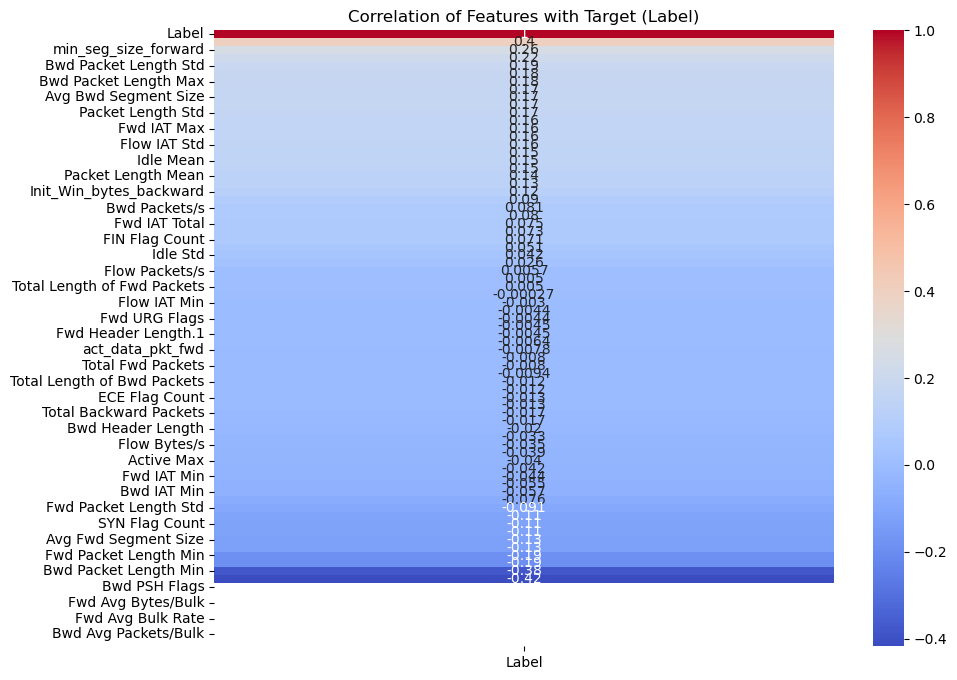

In [10]:
# Compute correlation matrix
corr_matrix = df.corr()

# Show correlation of features with target label
target_corr = corr_matrix["Label"].sort_values(ascending=False)
print("\nTop Correlated Features with Label:\n", target_corr.head(10))

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr()[["Label"]].sort_values("Label", ascending=False), annot=True, cmap="coolwarm")
plt.title("Correlation of Features with Target (Label)")
plt.show()

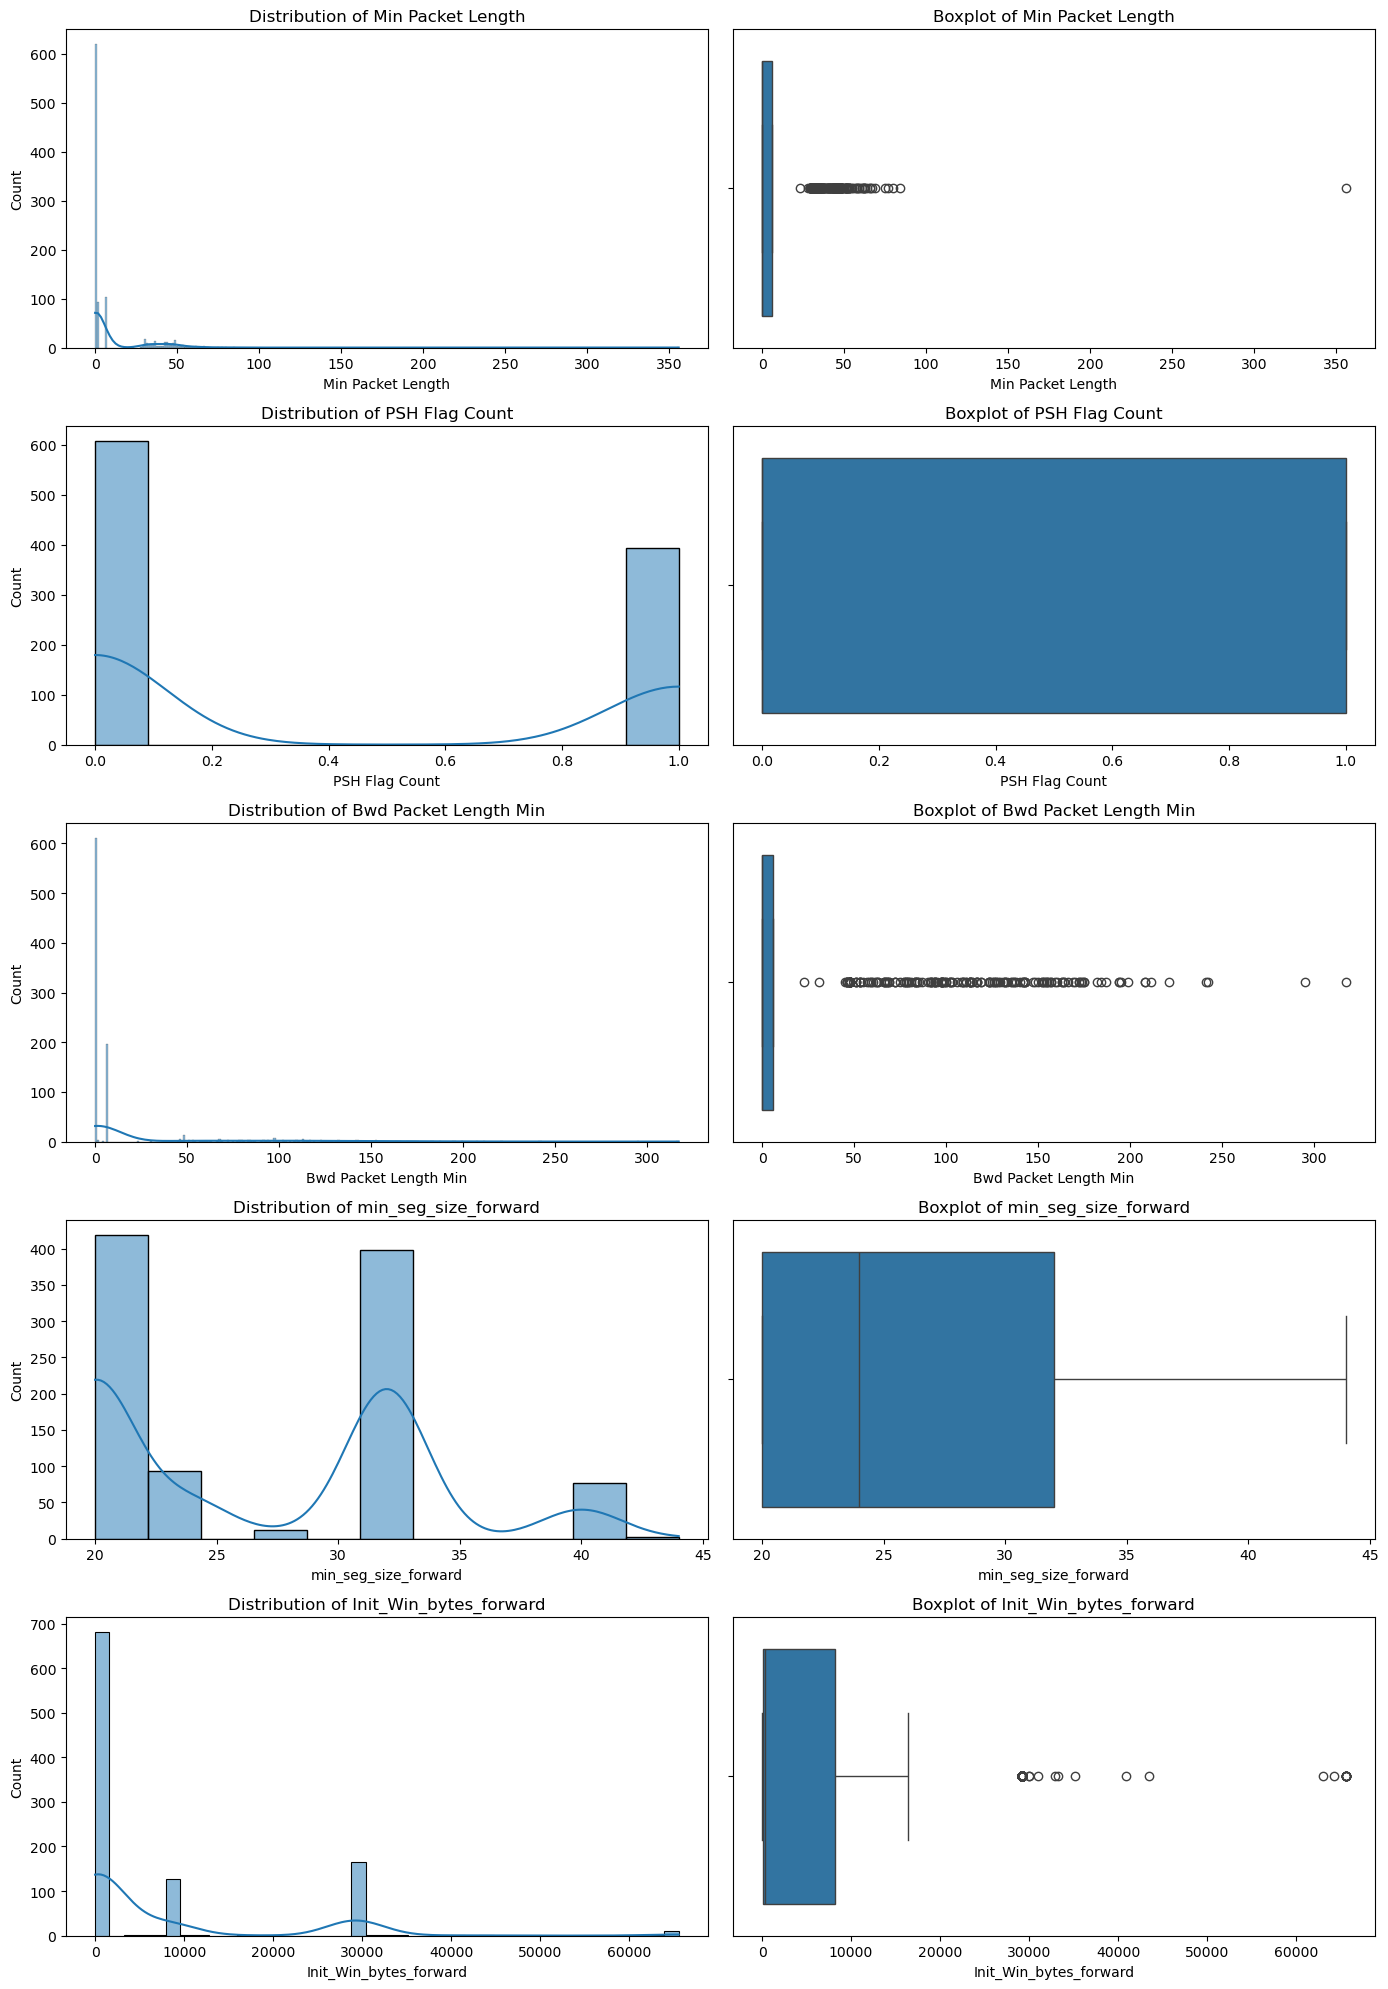

In [11]:
# Get numeric columns excluding 'Label'
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
if 'Label' in numeric_cols:
    numeric_cols.remove('Label')

# Include 'Label' for correlation analysis
full_numeric_df = df[numeric_cols + ['Label']].copy()

# Drop rows with NaN or Inf values
full_numeric_df.replace([np.inf, -np.inf], np.nan, inplace=True)
full_numeric_df.dropna(inplace=True)

# Drop constant columns (std = 0)
non_constant_cols = [col for col in full_numeric_df.columns if full_numeric_df[col].nunique() > 1]

# Final cleaned DataFrame
clean_df = full_numeric_df[non_constant_cols]

# Compute correlation with Label
correlations = clean_df.drop(columns='Label').corrwith(clean_df['Label']).abs().sort_values(ascending=False)

# Get top 5 correlated features
top_corr_features = correlations.head(5).index.tolist()

# Sample for visualization
sample_df = clean_df.sample(n=1000, random_state=42)

# Plot distributions and boxplots
plt.figure(figsize=(14, 20))

for i, col in enumerate(top_corr_features):
    # Distribution
    plt.subplot(len(top_corr_features), 2, 2*i + 1)
    sns.histplot(sample_df[col], kde=True)
    plt.title(f"Distribution of {col}")

    # Boxplot
    plt.subplot(len(top_corr_features), 2, 2*i + 2)
    sns.boxplot(x=sample_df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

In [12]:
# Copy the cleaned DataFrame (from step 8)
df_cleaned = clean_df.copy()

# Remove outliers from each of the top correlated numeric features
for col in top_corr_features:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)]

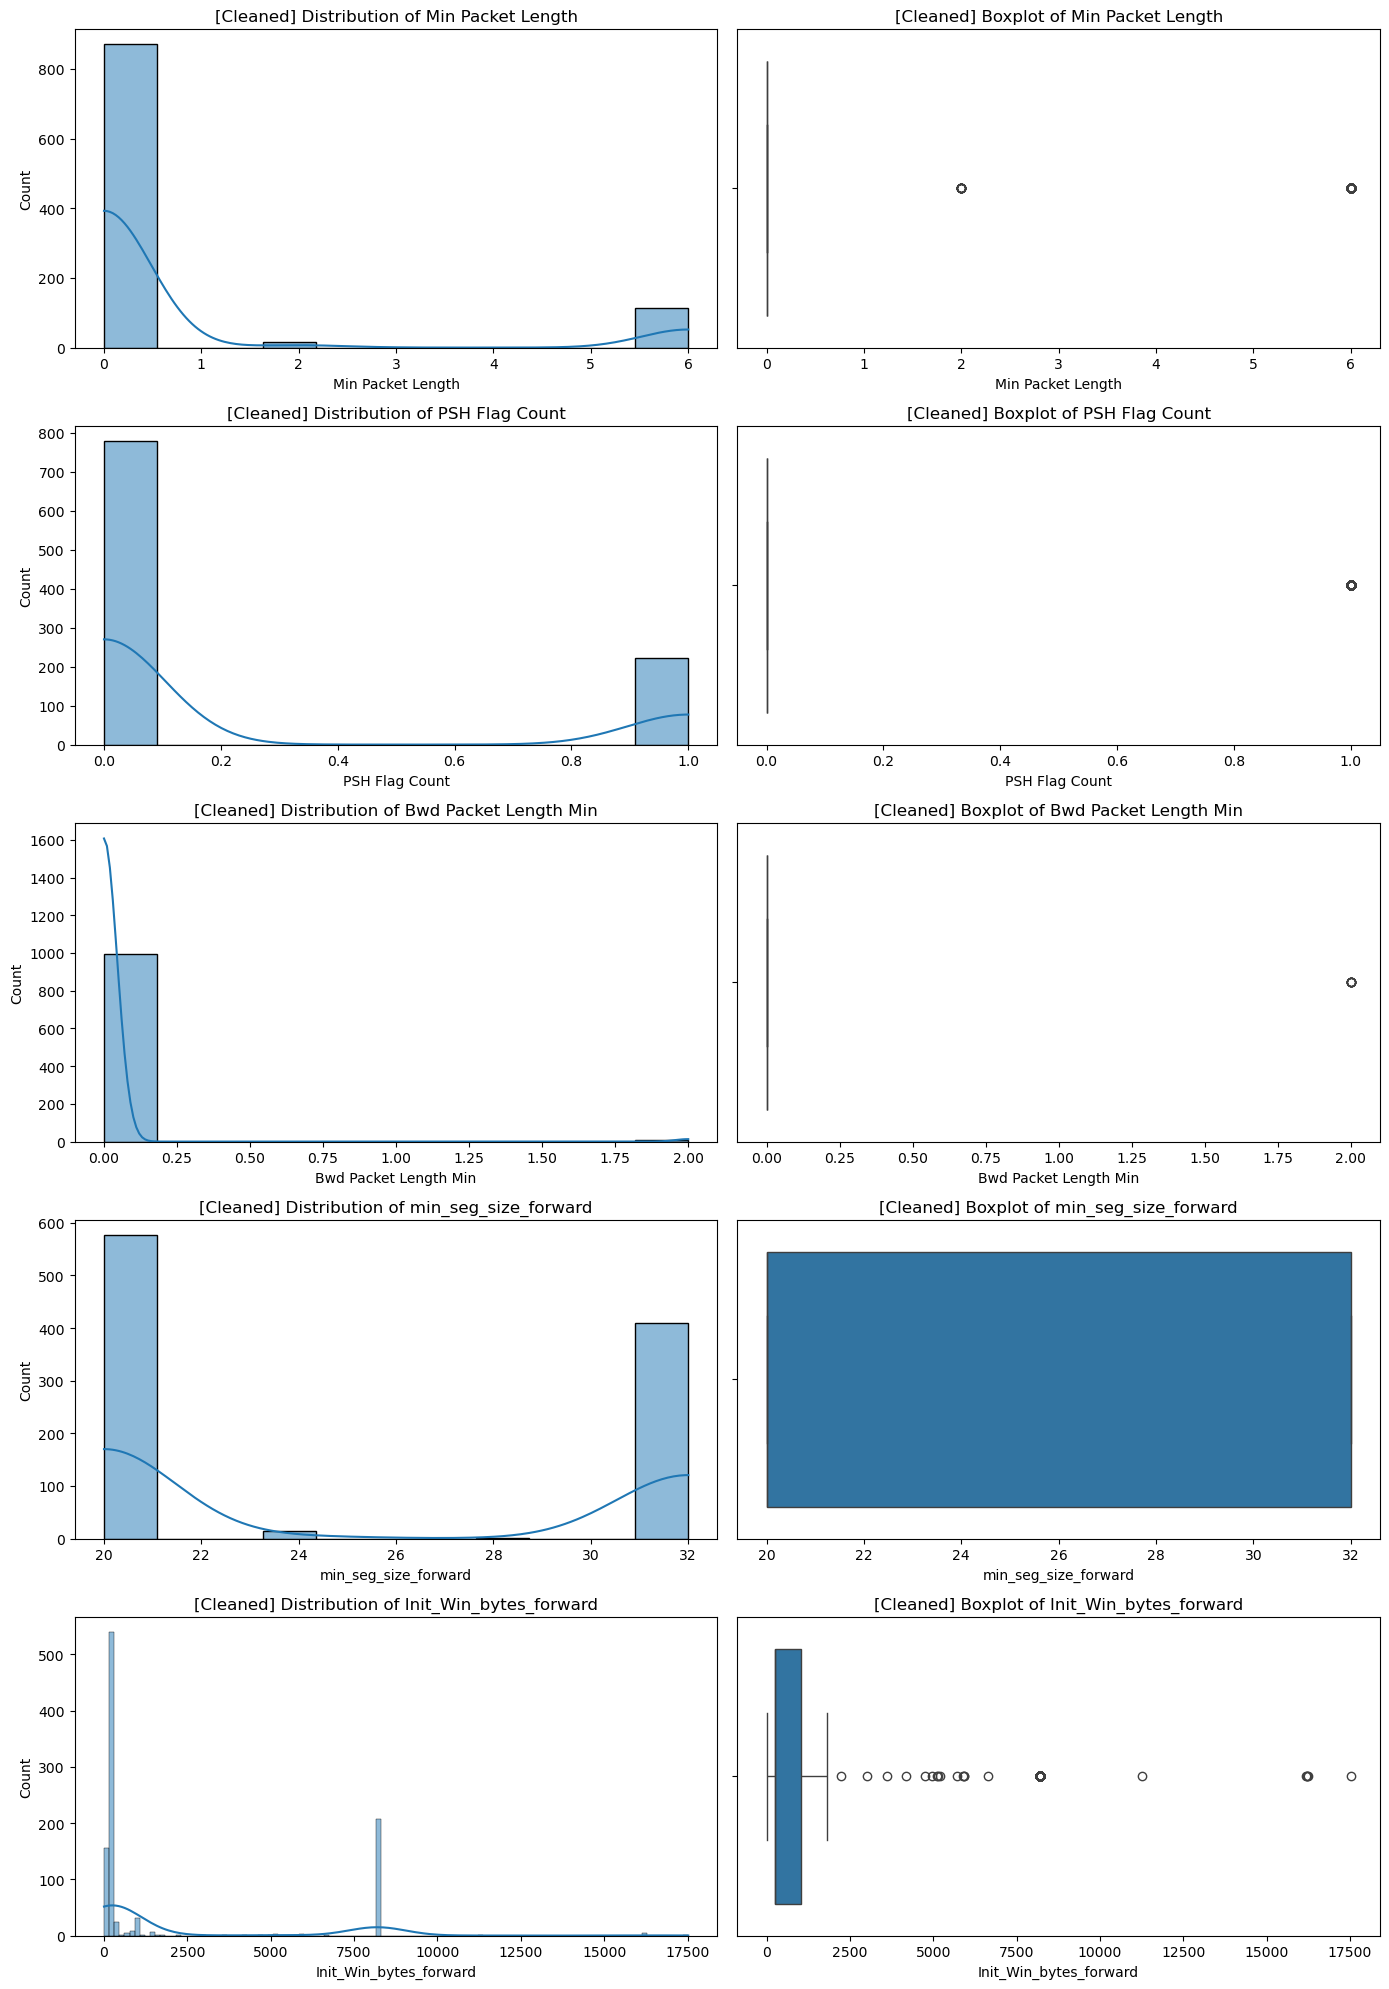

In [13]:
# Sample the cleaned DataFrame after outlier removal
sample_df = df_cleaned.sample(n=1000, random_state=42)

# Plot distribution and boxplot again
plt.figure(figsize=(14, 20))

for i, col in enumerate(top_corr_features):
    # Distribution
    plt.subplot(len(top_corr_features), 2, 2*i + 1)
    sns.histplot(sample_df[col], kde=True)
    plt.title(f"[Cleaned] Distribution of {col}")

    # Boxplot
    plt.subplot(len(top_corr_features), 2, 2*i + 2)
    sns.boxplot(x=sample_df[col])
    plt.title(f"[Cleaned] Boxplot of {col}")

plt.tight_layout()
plt.show()

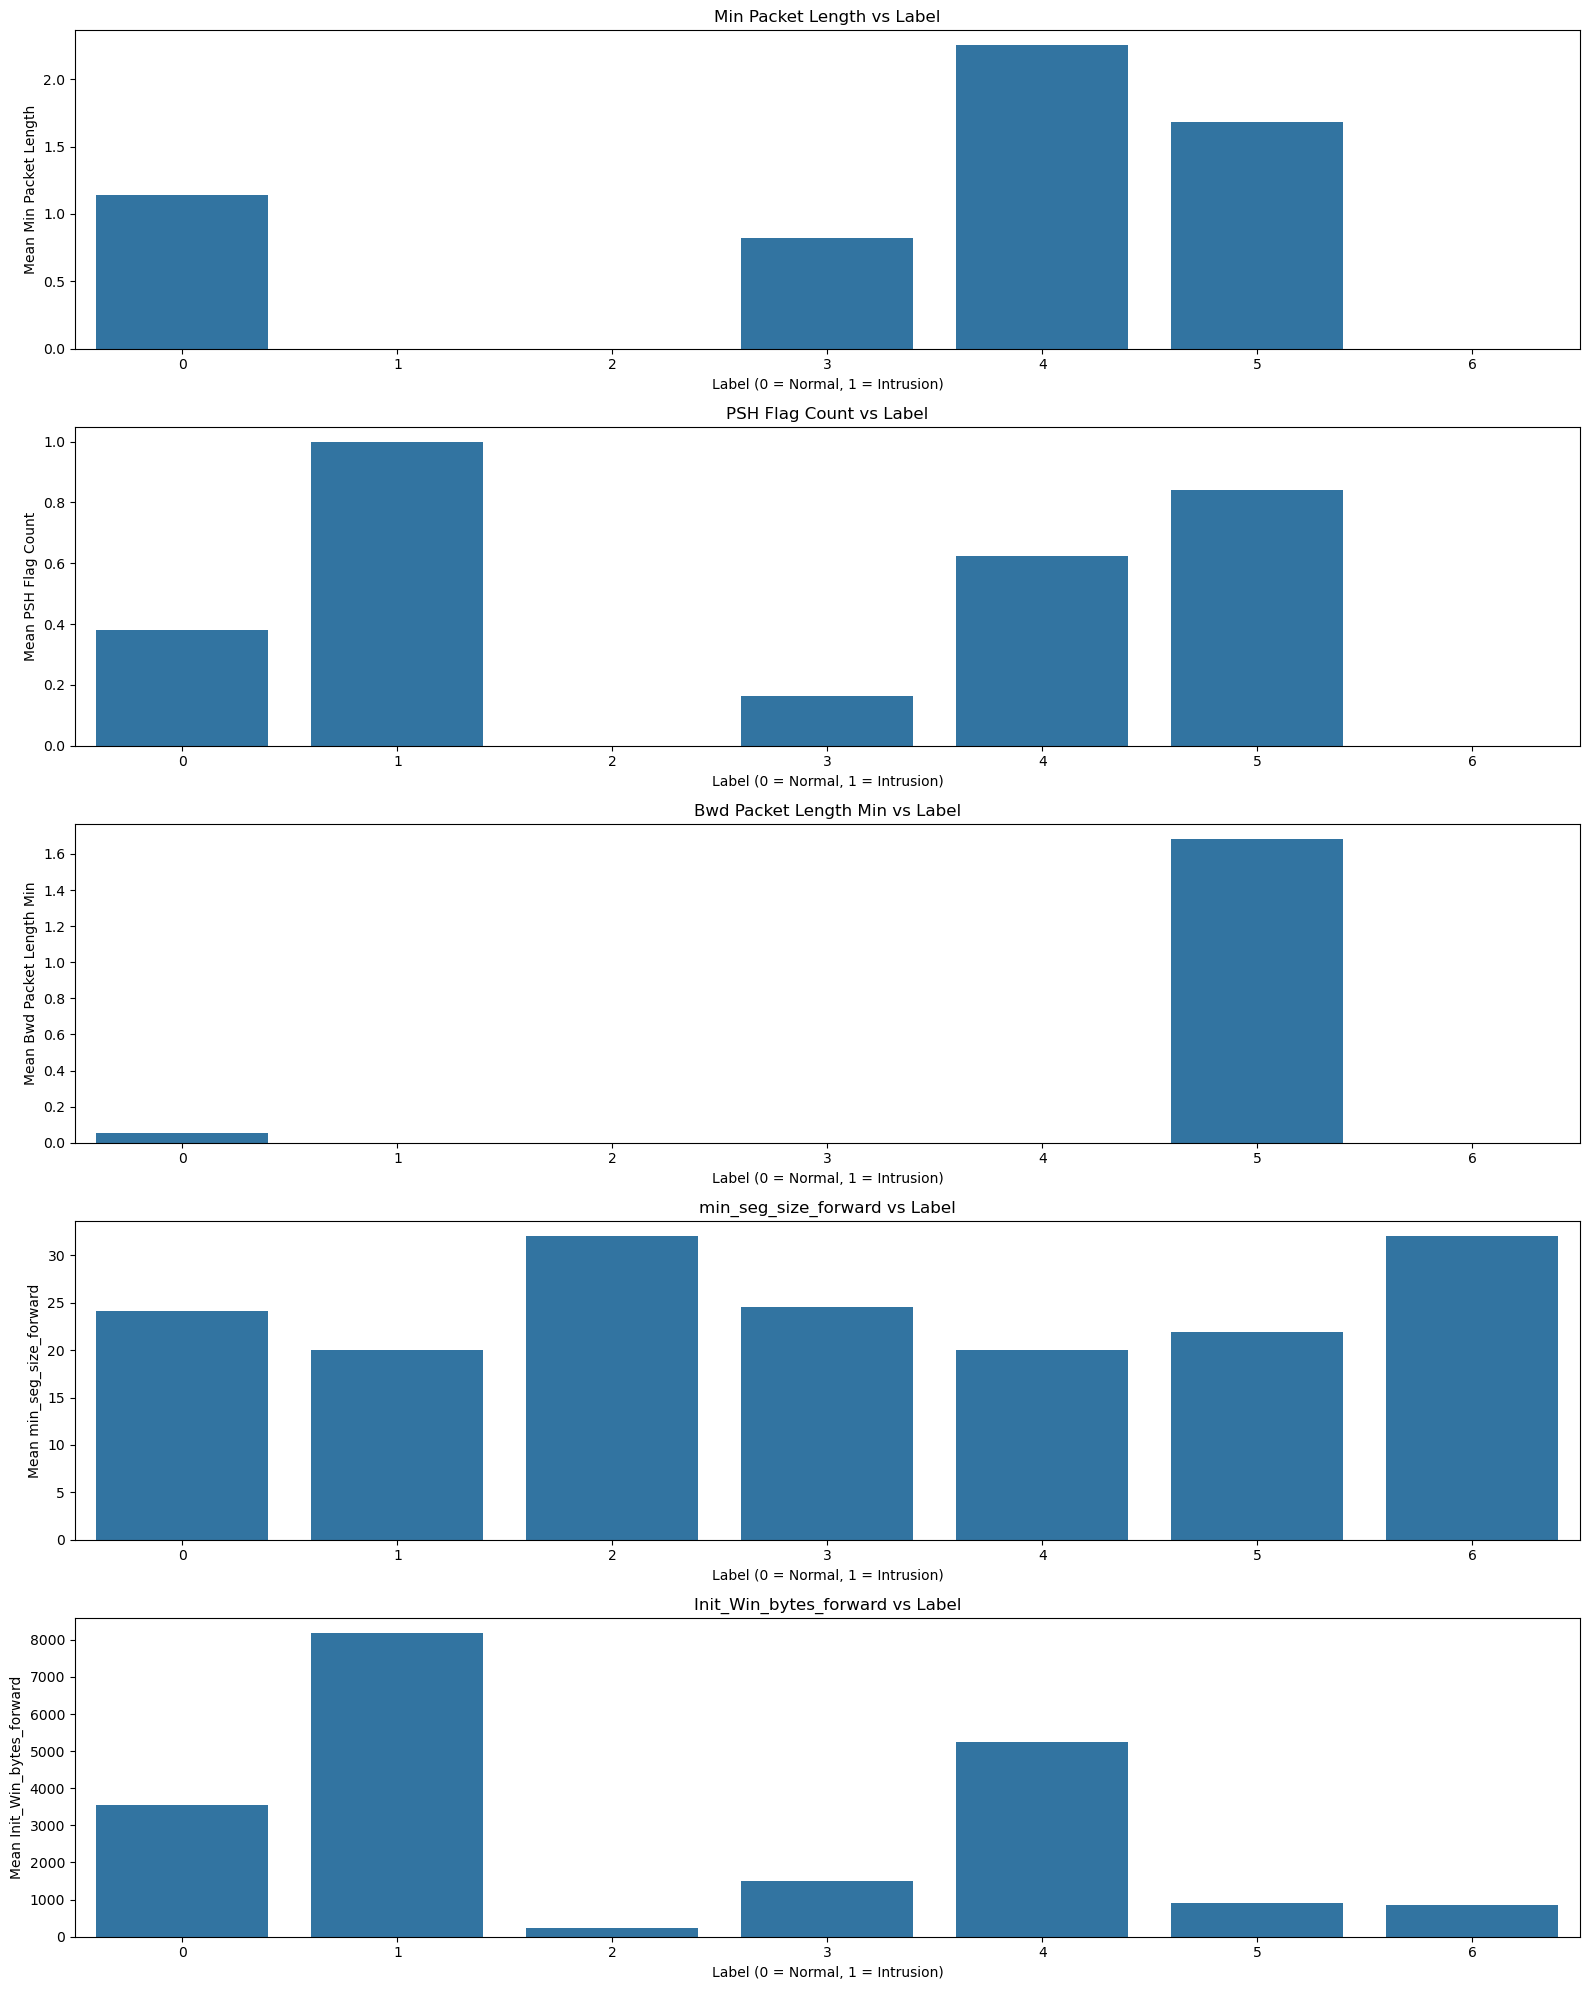

In [14]:
# Bar plots showing mean value of each feature grouped by 'Label'
plt.figure(figsize=(16, 4 * len(top_corr_features)))

for i, col in enumerate(top_corr_features):
    plt.subplot(len(top_corr_features), 1, i + 1)
    sns.barplot(x='Label', y=col, data=df_cleaned, errorbar=None)
    plt.title(f"{col} vs Label")
    plt.xlabel("Label (0 = Normal, 1 = Intrusion)")
    plt.ylabel(f"Mean {col}")

plt.tight_layout()
plt.show()

In [15]:
# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# Function to plot ROC curve in a separate figure
def plot_individual_roc(fpr, tpr, roc_auc, model_name):
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')  
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

### Logistic Regression 
This model is used for binary classification tasks, predicting the probability of a target variable based on one or more predictor variables. It applies the logistic function to model the relationship between the input features and the binary outcome, making it suitable for scenarios where the output is categorical.

Logistic Regression:

Accuracy: 0.9115830342961351
F1 Score: 0.910821751963953
Precision: 0.912286828773514
Recall: 0.9115830342961351
ROC AUC: 0.959584826891265
Confusion Matrix:
 [[5709 1039]
 [ 464 9787]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      6748
           1       0.90      0.95      0.93     10251

    accuracy                           0.91     16999
   macro avg       0.91      0.90      0.91     16999
weighted avg       0.91      0.91      0.91     16999


True Positives: 9787
False Positives: 1039
True Negatives: 5709
False Negatives: 464



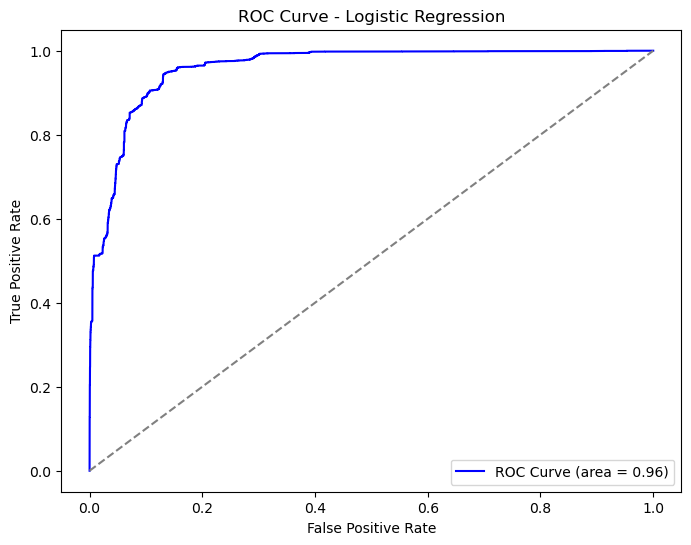

In [17]:
# Logistic Regression Model
lr = LogisticRegression(max_iter=1000)  # Initialize model with max iterations
lr.fit(X_train, y_train)  # Train model
y_pred_lr = lr.predict(X_test)  # Predict on test set
y_pred_prob_lr = lr.predict_proba(X_test)[:, 1]  # Get predicted probabilities for ROC AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)  # Calculate ROC curve
roc_auc_lr = roc_auc_score(y_test, y_pred_prob_lr)  # ROC AUC score
print("Logistic Regression:")
print()
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_lr, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_lr, average='weighted'))
print("ROC AUC:", roc_auc_lr)  # ROC AUC score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print()

# True/False positive-Nagative values for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
print(f"True Positives: {tp_lr}")
print(f"False Positives: {fp_lr}")
print(f"True Negatives: {tn_lr}")
print(f"False Negatives: {fn_lr}")
print()

# Plot ROC for Logistic Regression
plot_individual_roc(fpr_lr, tpr_lr, roc_auc_lr, 'Logistic Regression')

### Decision Tree
A decision tree is a flowchart-like structure that makes decisions based on the values of input features. It recursively splits the dataset into subsets based on feature values, creating branches that lead to final predictions at the leaves. This model is intuitive and easy to interpret but can be prone to overfitting.

Decision Tree:

Accuracy: 0.9952938408141655
F1 Score: 0.9952927623584045
Precision: 0.9952940159560982
Recall: 0.9952938408141655
ROC AUC: 0.9948267874685639
Confusion Matrix:
 [[ 6699    49]
 [   31 10220]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      6748
           1       1.00      1.00      1.00     10251

    accuracy                           1.00     16999
   macro avg       1.00      0.99      1.00     16999
weighted avg       1.00      1.00      1.00     16999


True Positives: 10220
False Positives: 49
True Negatives: 6699
False Negatives: 31



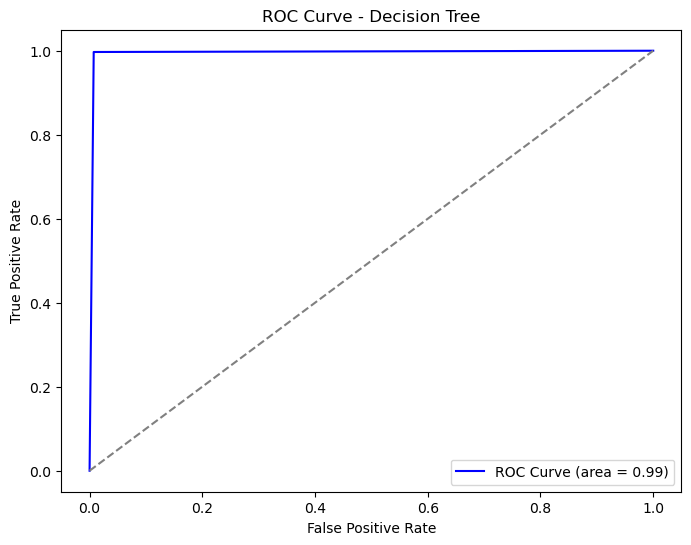

In [18]:
# Decision Tree Model
dt = DecisionTreeClassifier(random_state=42)  # Initialize model
dt.fit(X_train, y_train)  # Train model
y_pred_dt = dt.predict(X_test)  # Predict on test set
y_pred_prob_dt = dt.predict_proba(X_test)[:, 1]  # Get predicted probabilities for ROC AUC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_dt)  # Calculate ROC curve
roc_auc_dt = roc_auc_score(y_test, y_pred_prob_dt)  # ROC AUC score
print("Decision Tree:")
print()
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_dt, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_dt, average='weighted'))
print("ROC AUC:", roc_auc_dt)  # ROC AUC score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print()

# True/False positive-Nagative values for DECISION TREE
cm_dt = confusion_matrix(y_test, y_pred_dt)
tn_dt, fp_dt, fn_dt, tp_dt = cm_dt.ravel()
print(f"True Positives: {tp_dt}")
print(f"False Positives: {fp_dt}")
print(f"True Negatives: {tn_dt}")
print(f"False Negatives: {fn_dt}")
print()

# Plot ROC for Decision Tree
plot_individual_roc(fpr_dt, tpr_dt, roc_auc_dt, 'Decision Tree')

### Random Forest
This ensemble learning method constructs multiple decision trees during training and outputs the mode of their predictions for classification tasks. By averaging the results of various trees, it reduces the risk of overfitting and improves accuracy, making it robust against noise in the data.

Random Forest:

Accuracy: 0.9961174186716866
F1 Score: 0.9961178109267582
Precision: 0.9961186636444893
Recall: 0.9961174186716866
ROC AUC: 0.9996160465383486
Confusion Matrix:
 [[ 6719    29]
 [   37 10214]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      6748
           1       1.00      1.00      1.00     10251

    accuracy                           1.00     16999
   macro avg       1.00      1.00      1.00     16999
weighted avg       1.00      1.00      1.00     16999


True Positives: 10214
False Positives: 29
True Negatives: 6719
False Negatives: 37



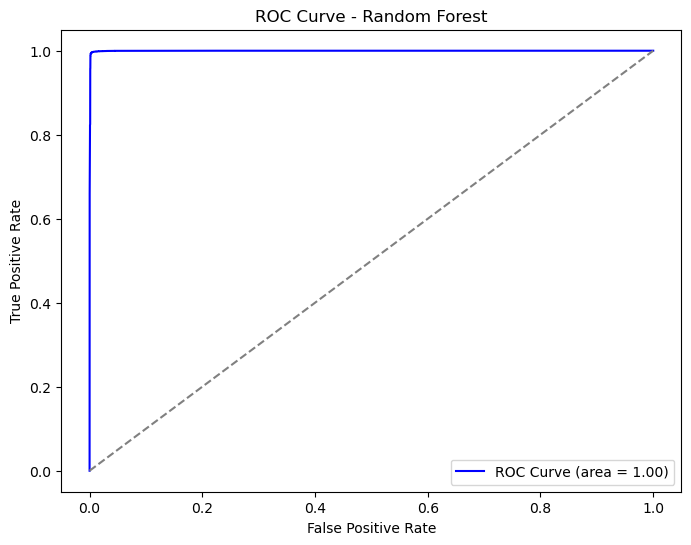

In [19]:
# Random Forest Model
rf = RandomForestClassifier(random_state=42)  # Initialize model
rf.fit(X_train, y_train)  # Train model
y_pred_rf = rf.predict(X_test)  # Predict on test set
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]  # Get predicted probabilities for ROC AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)  # Calculate ROC curve
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)  # ROC AUC score
print("Random Forest:")
print()
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print("ROC AUC:", roc_auc_rf)  # ROC AUC score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print()

# True/False positive-Nagative values for RANDOM FOREST
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
print(f"True Positives: {tp_rf}")
print(f"False Positives: {fp_rf}")
print(f"True Negatives: {tn_rf}")
print(f"False Negatives: {fn_rf}")
print()

# Plot ROC for Random Forest
plot_individual_roc(fpr_rf, tpr_rf, roc_auc_rf, 'Random Forest')

### Support Vector Machine (SVM)
SVM is a powerful classification algorithm that finds the optimal hyperplane to separate different classes in the feature space. It can handle both linear and non-linear classification problems by using kernel functions, which transform the input space into higher dimensions for better separation.

Support Vector Machine:

Accuracy: 0.9097593976116242
F1 Score: 0.9089335294033805
Precision: 0.9105796313347418
Recall: 0.9097593976116242
ROC AUC: 0.9612026516186458
Confusion Matrix:
 [[5678 1070]
 [ 464 9787]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      6748
           1       0.90      0.95      0.93     10251

    accuracy                           0.91     16999
   macro avg       0.91      0.90      0.90     16999
weighted avg       0.91      0.91      0.91     16999


True Positives: 9787
False Positives: 1070
True Negatives: 5678
False Negatives: 464



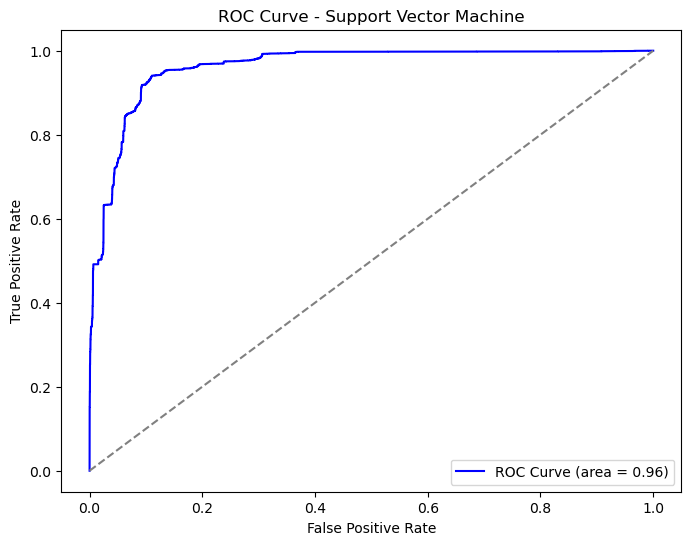

In [20]:
# Use LinearSVC (Much Faster than SVC)
svm_base = LinearSVC(dual=False, max_iter=5000)  # Set higher max_iter if needed
svm = CalibratedClassifierCV(svm_base)  # Add probability estimation

# Train Model (This will be MUCH faster)
svm.fit(X_train, y_train)

# Predictions
y_pred_svm = svm.predict(X_test)
y_pred_prob_svm = svm.predict_proba(X_test)[:, 1]  # Get probability estimates

# Evaluation
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_prob_svm)

print("Support Vector Machine:")
print()
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))
print("ROC AUC:", roc_auc_svm)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print()

# True/False positive-Nagative values for SUPPORT VECTOR MACHINE
cm_svm = confusion_matrix(y_test, y_pred_svm)
tn_svm, fp_svm, fn_svm, tp_svm = cm_svm.ravel()
print(f"True Positives: {tp_svm}")
print(f"False Positives: {fp_svm}")
print(f"True Negatives: {tn_svm}")
print(f"False Negatives: {fn_svm}")
print()

# Plot ROC for Support Vector Machine
plot_individual_roc(fpr_svm, tpr_svm, roc_auc_svm, 'Support Vector Machine')

### K-Nearest Neighbors (KNN)
KNN is a simple, instance-based learning algorithm that classifies a data point based on the majority class of its 'k' nearest neighbors in the feature space. It uses distance metrics to determine proximity, making it effective for classification tasks but computationally expensive for large datasets.

K-Nearest Neighbors:

Accuracy: 0.9832343079004647
F1 Score: 0.9832130961164457
Precision: 0.983258984211611
Recall: 0.9832343079004647
ROC AUC: 0.9941274397911763
Confusion Matrix:
 [[ 6557   191]
 [   94 10157]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      6748
           1       0.98      0.99      0.99     10251

    accuracy                           0.98     16999
   macro avg       0.98      0.98      0.98     16999
weighted avg       0.98      0.98      0.98     16999


K-Nearest Neighbors:
True Positives: 10157
False Positives: 191
True Negatives: 6557
False Negatives: 94



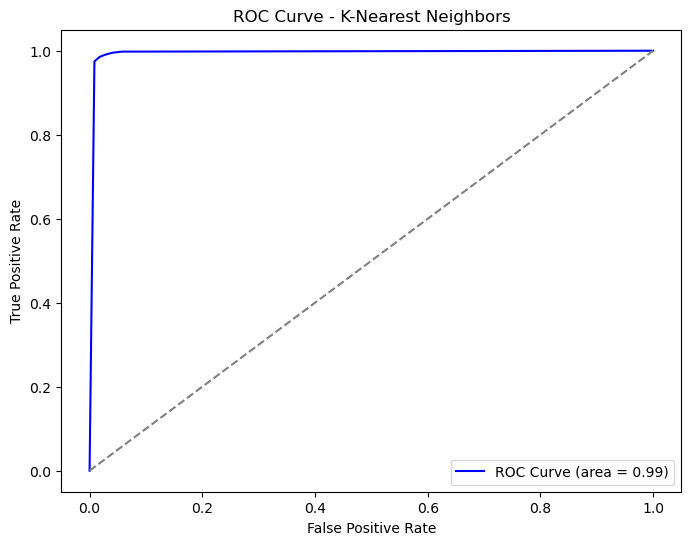

In [21]:
# K-Nearest Neighbors Model
knn = KNeighborsClassifier(n_neighbors=5)  # Initialize model with k=5
knn.fit(X_train, y_train)  # Train model
y_pred_knn = knn.predict(X_test)  # Predict on test set
y_pred_prob_knn = knn.predict_proba(X_test)[:, 1]  # Get predicted probabilities for ROC AUC
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)  # Calculate ROC curve
roc_auc_knn = roc_auc_score(y_test, y_pred_prob_knn)  # ROC AUC score
print("K-Nearest Neighbors:")
print()
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("F1 Score:", f1_score(y_test, y_pred_knn, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_knn, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_knn, average='weighted'))
print("ROC AUC:", roc_auc_knn)  # ROC AUC score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print()

# True/False positive-Nagative values for K-NEAREST NEIGHBORS
cm_knn = confusion_matrix(y_test, y_pred_knn)
tn_knn, fp_knn, fn_knn, tp_knn = cm_knn.ravel()
print("K-Nearest Neighbors:")
print(f"True Positives: {tp_knn}")
print(f"False Positives: {fp_knn}")
print(f"True Negatives: {tn_knn}")
print(f"False Negatives: {fn_knn}")
print()

# Plot ROC for K-Nearest Neighbors
plot_individual_roc(fpr_knn, tpr_knn, roc_auc_knn, 'K-Nearest Neighbors')

### Gaussian Naive Bayes
This probabilistic classifier applies Bayes' theorem, assuming independence among features. It calculates the probability of each class given the input features and selects the class with the highest probability. Gaussian Naive Bayes is particularly effective for text classification and scenarios with high-dimensional data.

Gaussian Naive Bayes:

Accuracy: 0.7292781928348726
F1 Score: 0.6867233768921391
Precision: 0.8016527873516689
Recall: 0.7292781928348726
ROC AUC: 0.8041533689919477
Confusion Matrix:
 [[ 2219  4529]
 [   73 10178]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.33      0.49      6748
           1       0.69      0.99      0.82     10251

    accuracy                           0.73     16999
   macro avg       0.83      0.66      0.65     16999
weighted avg       0.80      0.73      0.69     16999


Gaussian Naive Bayes:
True Positives: 10178
False Positives: 4529
True Negatives: 2219
False Negatives: 73



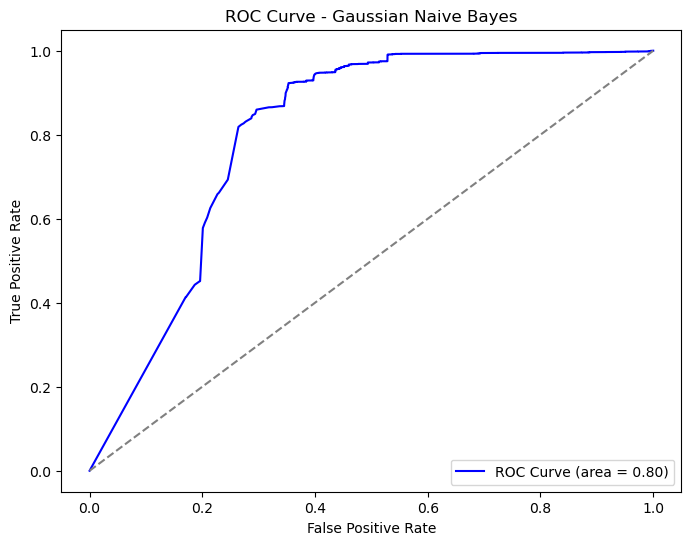

In [22]:
# Gaussian Naive Bayes Model
nb = GaussianNB()  # Initialize Naive Bayes model
nb.fit(X_train, y_train)  # Train model
y_pred_nb = nb.predict(X_test)  # Predict on test set
y_pred_prob_nb = nb.predict_proba(X_test)[:, 1]  # Get predicted probabilities for ROC AUC
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_prob_nb)  # Calculate ROC curve
roc_auc_nb = roc_auc_score(y_test, y_pred_prob_nb)  # ROC AUC score
print("Gaussian Naive Bayes:")
print()
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1 Score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))
print("ROC AUC:", roc_auc_nb)  # ROC AUC score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print()

# True/False positive-Nagative values for GAUSSIAN NAIVE BAYES
cm_nb = confusion_matrix(y_test, y_pred_nb)
tn_nb, fp_nb, fn_nb, tp_nb = cm_nb.ravel()
print("Gaussian Naive Bayes:")
print(f"True Positives: {tp_nb}")
print(f"False Positives: {fp_nb}")
print(f"True Negatives: {tn_nb}")
print(f"False Negatives: {fn_nb}")
print()

# Plot ROC for Gaussian Naive Bayes
plot_individual_roc(fpr_nb, tpr_nb, roc_auc_nb, 'Gaussian Naive Bayes')

In [23]:
# Compare model performance and select the best model based on accuracy
models = {
    'Logistic Regression': accuracy_score(y_test, y_pred_lr),
    'Decision Tree': accuracy_score(y_test, y_pred_dt),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'Support Vector Machine': accuracy_score(y_test, y_pred_svm),
    'K-Nearest Neighbors': accuracy_score(y_test, y_pred_knn),
    'Gaussian Naive Bayes': accuracy_score(y_test, y_pred_nb)
}

# Identify the model with the highest accuracy
best_model_name = max(models, key=models.get)
print(f"Best model selected: {best_model_name} with accuracy {models[best_model_name]:.4f}")

Best model selected: Random Forest with accuracy 0.9961


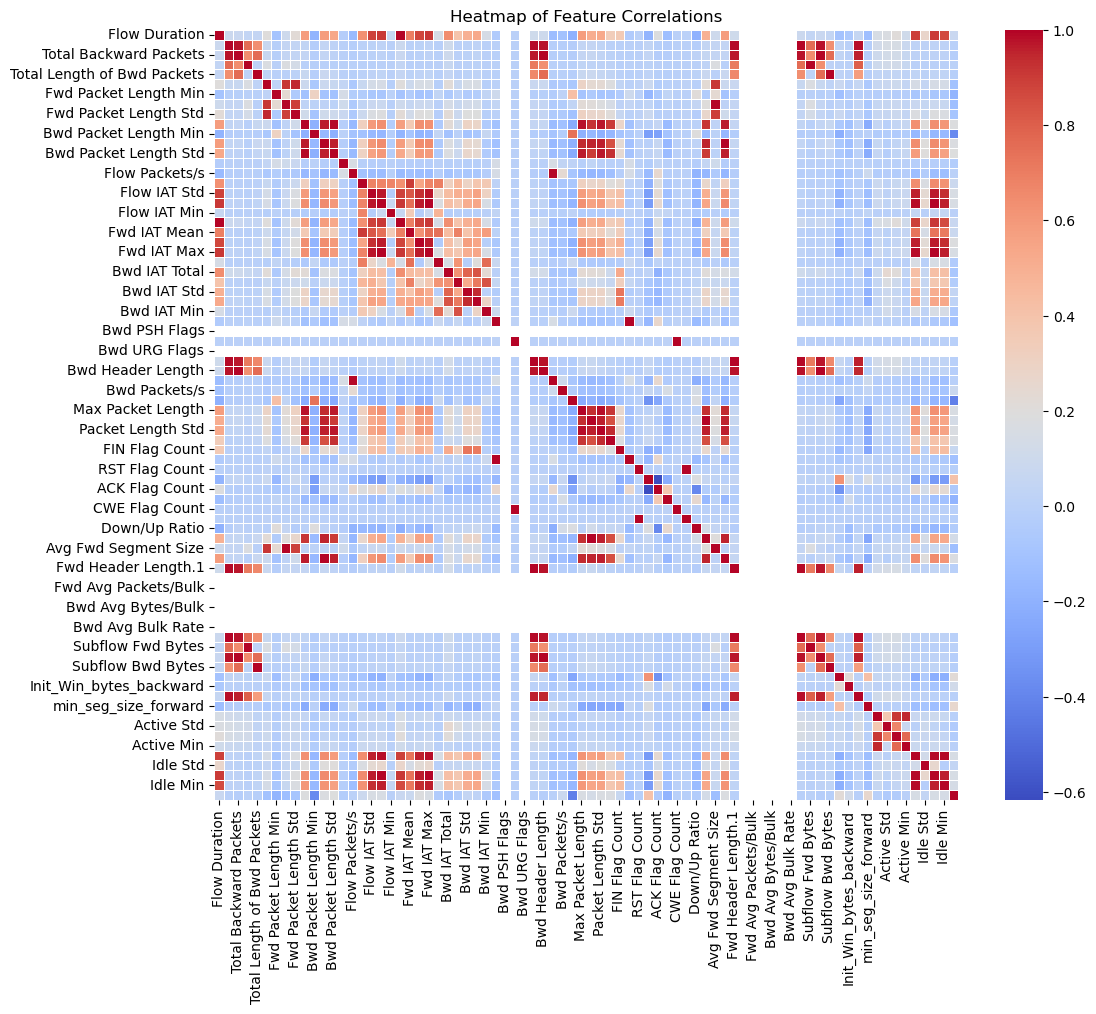

In [24]:
# HEATMAP - Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

Model Accuracy Scores:

Logistic Regression: 91.16%
Decision Tree: 99.53%
Random Forest: 99.61%
SVM: 90.98%
KNN: 98.32%
Naive Bayes: 72.93%


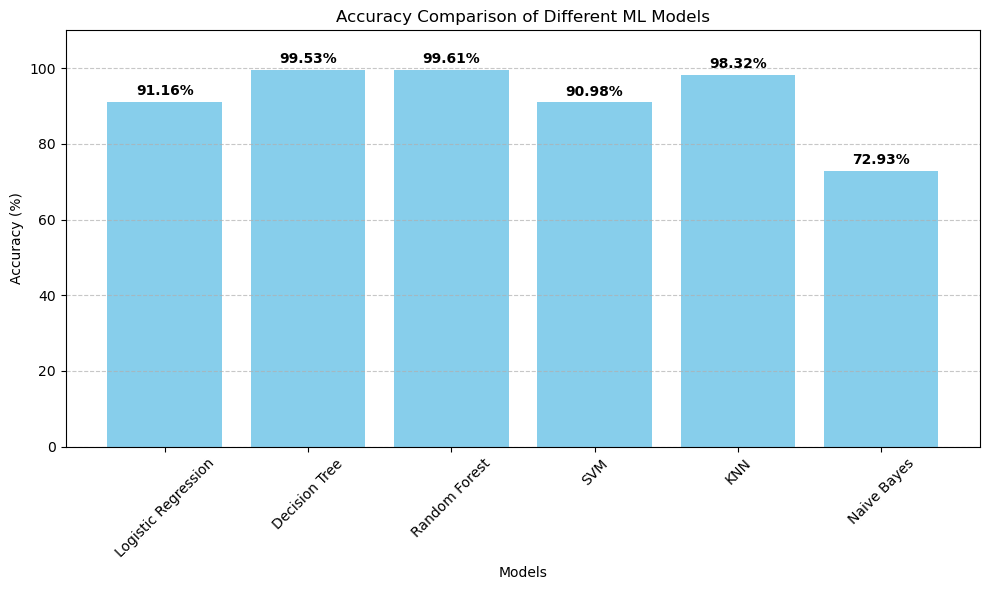

In [25]:
# Dictionary of model names and their accuracy percentages
accuracies = {
    'Logistic Regression': accuracy_score(y_test, y_pred_lr) * 100,
    'Decision Tree': accuracy_score(y_test, y_pred_dt) * 100,
    'Random Forest': accuracy_score(y_test, y_pred_rf) * 100,
    'SVM': accuracy_score(y_test, y_pred_svm) * 100,
    'KNN': accuracy_score(y_test, y_pred_knn) * 100,
    'Naive Bayes': accuracy_score(y_test, y_pred_nb) * 100
}

# Print each accuracy on a new line
print("Model Accuracy Scores:")
print()
for model, acc in accuracies.items():
    print(f"{model}: {acc:.2f}%")

plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')

# Add accuracy values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Set plot labels and styling
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Different ML Models')
plt.ylim(0, 110)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
# Create an empty dictionary to store inference results
inference_results = {}

# List of trained models
models = {
    "Logistic Regression": lr,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Support Vector Machine": svm,
    "K-Nearest Neighbors": knn,
    "Gaussian Naive Bayes": nb,
}

# Generate predictions for each model and store counts of 0s and 1s
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    count_no = np.sum(y_pred == 0)  # Count of class 0 (No)
    count_yes = np.sum(y_pred == 1)  # Count of class 1 (Yes)
    inference_results[model_name] = [count_no, count_yes]

# Convert the dictionary to a DataFrame
inference_df = pd.DataFrame.from_dict(
    inference_results, orient="index", columns=["0 (No)", "1 (Yes)"]
)

# Display the inference table
print("Inference Table:")
print(inference_df)

# Save the inference table to a CSV file for presentation
inference_df.to_csv("inference_results.csv", index=True)


Inference Table:
                        0 (No)  1 (Yes)
Logistic Regression       6173    10826
Decision Tree             6730    10269
Random Forest             6756    10243
Support Vector Machine    6142    10857
K-Nearest Neighbors       6651    10348
Gaussian Naive Bayes      2292    14707


In [27]:
# Retrieve the best model instance
best_model = {
    'Logistic Regression': lr,
    'Decision Tree': dt,
    'Random Forest': rf,
    'Support Vector Machine': svm,
    'K-Nearest Neighbors': knn,
    'Gaussian Naive Bayes': nb
}[best_model_name]

In [28]:
#Save the best model to a file
joblib.dump(best_model, 'best_final_model.pkl')

# Load the best model and make predictions
loaded_model = joblib.load('best_final_model.pkl')
new_predictions = loaded_model.predict(X_test)
print("Loaded Model Predictions:")
print("Accuracy:", accuracy_score(y_test, new_predictions))

Loaded Model Predictions:
Accuracy: 0.9961174186716866


In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']